In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import HiveContext

In [2]:
#Create a spark application
spark = SparkSession.builder \
.appName("ReadingFromHive") \
.master("local") \
.enableHiveSupport() \
.getOrCreate()

In [5]:
df = spark.sql("select * from netflix_new where age is not null")

In [6]:
df.show(5)

+---+------------+
|age|subscription|
+---+------------+
| 62|           1|
| 18|           0|
| 40|           0|
| 51|           1|
| 37|           1|
+---+------------+
only showing top 5 rows



## Correlation between dependent and independent variables

<Figure size 720x720 with 0 Axes>

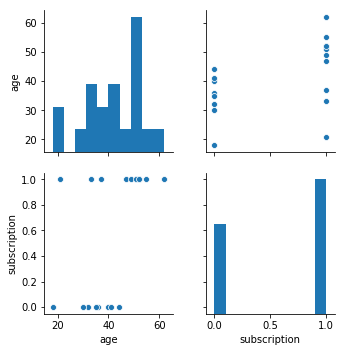

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

df_pd = df.toPandas()
plt.figure(figsize=(10,10))
sns.pairplot(data=df_pd)
plt.show()

In [9]:
df_pd.corr()

,age,subscription
age,1.000000,0.533445
subscription,0.533445,1.000000


## Building linear regression model

In [22]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [13]:
vec_assembler = VectorAssembler(inputCols=['age'],outputCol='features')

In [14]:
features_df = vec_assembler.transform(df)

In [15]:
features_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- subscription: integer (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
model_df = features_df.select('features','subscription')

In [17]:
model_df.show(5)

+--------+------------+
|features|subscription|
+--------+------------+
|  [62.0]|           1|
|  [18.0]|           0|
|  [40.0]|           0|
|  [51.0]|           1|
|  [37.0]|           1|
+--------+------------+
only showing top 5 rows



In [18]:
#Split the data
train_df,test_df = model_df.randomSplit([0.7,0.3])

In [19]:
print(train_df.count(),len(train_df.columns))

15 2


In [20]:
print(test_df.count(),len(test_df.columns))

5 2


In [23]:
lin_reg = LinearRegression(labelCol='subscription')

In [24]:
lr_model = lin_reg.fit(train_df)

In [25]:
lr_model.intercept

-0.3783941737097571

In [26]:
print(lr_model.coefficients)

[0.023332134508181814]


In [27]:
training_pred = lr_model.evaluate(train_df)

In [30]:
test_result = lr_model.evaluate(test_df)

## Evaluating the model

###  RMSE for training and testing

In [28]:
# RMSE training
training_pred.rootMeanSquaredError

0.43148643439602313

In [31]:
# RMSE testing
test_result.rootMeanSquaredError

0.3582097823490889

### R2 for training and testing 

In [29]:
# R2 training
training_pred.r2

0.224247737217527

In [ ]:
# R2 testing
test_result.r2